## Анализ структуры данных и предобработка

In [2]:
import matplotlib
matplotlib.use('Qt5Agg')  # Использование Qt5Agg вместо TkAgg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


ModuleNotFoundError: No module named 'matplotlib'

In [24]:

# Загрузка данных в dataframe
data = pd.read_csv('./data/marketing_AB.csv')

data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [ ]:
#  Удаление дубликатов
data = data.drop_duplicates(subset=['user id',])

# Удаление отсутвующих значений
data = data.dropna()

In [26]:
#  Замена значений поля 'converted' для дальнейших расчетов
replacement_dict = {False: 0, True: 1}
data['converted'] = data['converted'].map(replacement_dict )

In [27]:
# Замена для удобства
replacement_dict = {'ad': 'A', 'psa': 'B'}
data['test group'] = data['test group'].map(replacement_dict )

In [29]:
daily_data = data.groupby(['most ads day', 'most ads hour', 'test group']).agg({
    'user id': 'count',
    'converted': 'sum'
}).reset_index().rename(columns={'user id': 'users count'})

In [30]:
daily_data

,most ads day,most ads hour,test group,users count,converted
0,Friday,0,A,807,16
1,Friday,0,B,34,0
2,Friday,1,A,662,7
3,Friday,1,B,29,0
4,Friday,2,A,825,10
...,...,...,...,...,...
330,Wednesday,21,B,153,2
331,Wednesday,22,A,3277,83
332,Wednesday,22,B,157,3
333,Wednesday,23,A,2884,64


In [37]:
# Вычисление конверсии
daily_data['conversion'] = daily_data['converted'] / daily_data['users count'] * 100

daily_data

,most ads day,most ads hour,test group,users count,converted,conversion
0,Friday,0,A,807,16,1.982652
1,Friday,0,B,34,0,0.000000
2,Friday,1,A,662,7,1.057402
3,Friday,1,B,29,0,0.000000
4,Friday,2,A,825,10,1.212121
...,...,...,...,...,...,...
330,Wednesday,21,B,153,2,1.307190
331,Wednesday,22,A,3277,83,2.532804
332,Wednesday,22,B,157,3,1.910828
333,Wednesday,23,A,2884,64,2.219140


/tmp/ipykernel_16520/1894770937.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_data, x='conversion', y='test group', orient='h', palette='Set2')


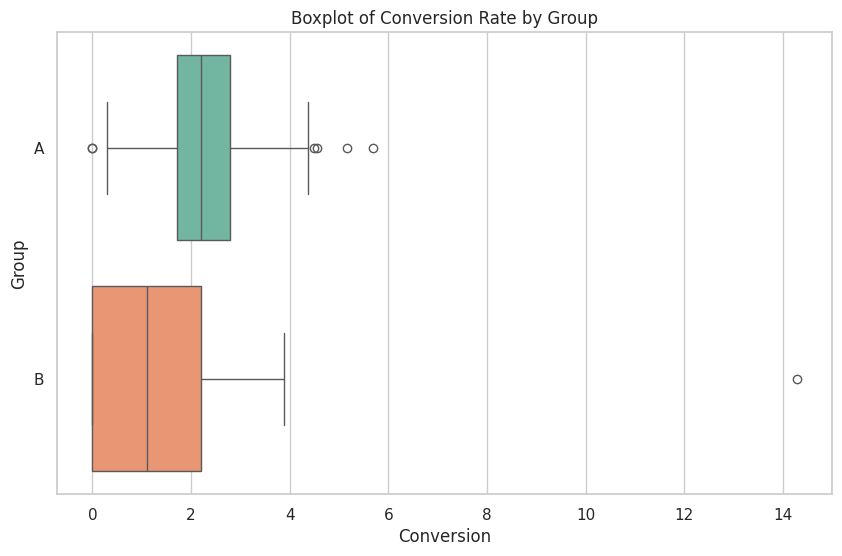

In [ ]:
%matplotlib inline

# График данных конверсии по группам 
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_data, x='conversion', y='test group', orient='h', palette='Set2')

# Настройка графика
plt.xlabel('Conversion')
plt.ylabel('Group')
plt.title('Boxplot of Conversion Rate by Group')

# Построить
plt.show()

In [ ]:

conversion_piv = daily_data.groupby('test group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
test group,,
A,2.284667,2.208447
B,1.328739,1.098901


Text(0.5, 1.0, 'График конверсии по дням')

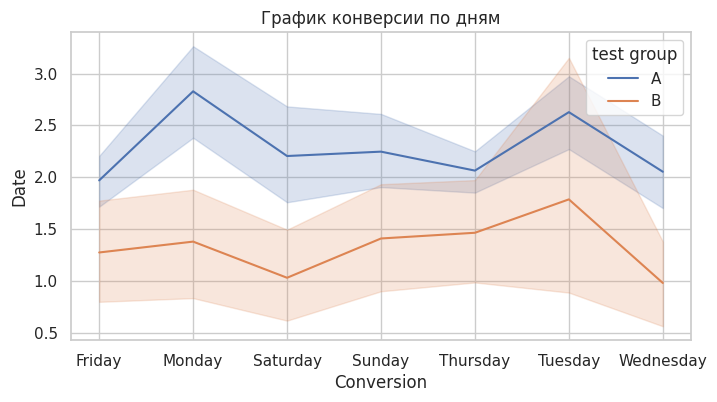

In [41]:
# График конверсии по дням недели
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=daily_data,
    x='most ads day',
    y='conversion',
    hue='test group')

# Adding labels and title
plt.xlabel('Conversion')
plt.ylabel('Date')
plt.title('График конверсии по дням')
